In [1]:
'''
Worked on by: Meena Hari and Tarini Singh.

Trained KNearestNeighbors on "All_Data.txt"
with K=[1,2,3,4,5, 6, 7, 10, 15, 20, 25, 30, 35, 50, 100, 300].

Made predictions using 1) arithmetic mean of 
neighbors' predictions, 2) geometric mean of 
neighbors' predictions, and 3) harmonic mean of 
neighbors' predictions.

Tested model on "Test_boards.txt" and recorded
various statistics (# times overestimated true output,
# of times overestimated manhattan heuristic, etc) of 
the models in order to find the optimal K 
and type of mean to use in making predictions.
'''

from numba import njit, jit
from scipy import stats
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, Flatten, Input
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.models import load_model
import keras.losses

from constants import *
import heuristic as h
import io_help as io
import neural_net as nn
import solver as s

def load_data(file_name):
    """
    Reads in training data from a file and returns 
    the boards in X and their labels in Y as a tuple. 
    (Function copied from "neural_net.py").
    """
    file = open(file_name, "r")
    X = []
    Y = []
    
    for string in file: 
        (board, dist) = io.string_to_board_and_dist(string)
        X_temp = np.concatenate((board.reshape(16)), axis=None)
        X.append(X_temp)
        Y.append(dist)
        
    file.close()
    X_train = np.asarray(X)
    Y_train = np.asarray(Y)
    return(X_train, Y_train)

Using TensorFlow backend.


In [2]:
def knn_test(X_test, X_train, Y_train, model):
    '''
    Returns model's predictions on X_test as a 
    numpy array of size: (# testing samples) x 3.
    
    X test: array of test boards, each with size (16,)
    X_train: array of training boards, each with size (16,)
    Y_train: array of true output for X_train.
    model: array of k-nearest neighbors for X_train generated by trained knn model.
    
    1st column of predictions is generated using arithmetic
    mean.
    2nd column of predictions is generated using geometric
    mean.
    3rd column of predictions is generated using harmonic
    mean.
    '''
    
    # Stores predictions of the knn model.
    preds = np.zeros((len(X_test),3))

    for i in range(len(X_test)):
        neigh_inds = model[1][i]
        res_mean = np.mean(Y_train[neigh_inds])
        res_gmean = stats.gmean(Y_train[neigh_inds])
        res_hmean = stats.hmean(Y_train[neigh_inds])
        preds[i, 0] = res_mean
        preds[i, 1] = res_gmean
        preds[i, 2] = res_hmean
        #mode = stats.mode(Y_train[neigh_inds])[0][0]
        
    return preds

In [3]:
def string_to_test_info(string):
    """
    Given a string containing the standard form of test info, returns tuple of 
    board, number of states to solution, time, and lenght of solution.
    (Function copied from "run_testing.py").
    """
    split = string.split("!")
    board = io.string_to_board(split[0])
    n_states = int(split[1])
    time = float(split[2])
    sol_len = int(split[3])
    return (board, n_states, time, sol_len)

def load_boards(filename):
    """
    Given name of file containing test boards, loads all test boards.
    (Function copied from "run_testing.py").
    """
    file = open(filename, "r")

    boards = []
    n_states = []
    times = []
    dists = []

    for line in file:
        (board, c_states, c_time, sol_len) = string_to_test_info(line)
        boards.append(board)
        n_states.append(c_states)
        times.append(c_time)
        dists.append(sol_len)

    return (boards, n_states, times, dists)

In [4]:
# Load dataset. X: board inputs, Y: true output.
(X_train,Y_train) = load_data('All_Data.txt')
print(X_train.shape)

(395715, 16)


In [5]:
# Load test boards.
(X_test_mt,_,_, Y_test) = load_boards('Test_boards.txt')
X_test = np.asarray(X_test_mt).reshape(len(X_test_mt),16)

In [6]:
# K-values to try during model training.
K = [1,2,3,4,5, 6, 7, 10, 15, 20, 25, 30, 35, 50, 100, 300]

# Store some statistics from model training to use for plotting.

avg_e_admiss_mean = []
perc_over_man_mean = []
perc_under_man_mean = []
perc_over_ham_mean = []


avg_e_admiss_gmean = []
perc_over_man_gmean = []
perc_under_man_gmean = []
perc_over_ham_gmean = []

# due to previous trials these are named with the suffix "mode"; think
# of this as representing "hmean" instead.
avg_e_admiss_mode = []
perc_over_man_mode = []
perc_under_man_mode = []
perc_over_ham_mode = []

In [7]:
for g in range(len(K)):
    print("Starting next K...")
    NEIGHBORS = K[g]
    
    # Generate knn model for g neighbors on X_train.
    knn_model = NearestNeighbors(n_neighbors=NEIGHBORS, n_jobs = -1).fit(X_train,Y_train)
    
    # Get neighbors of test samples.
    pred = knn_model.kneighbors(X_test)
    # Get predictions on test samples.
    model = knn_test(X_test, X_train, Y_train, pred)
    
    #### Calculating heuristics/statistics. ####
    
    # stats for knn with truncation + arithmetic mean.
    dist_over_mean_i = []
    misclass_mean_i = 0
    dist_under_mean_i = []
    dist_over_man_mean_i = []
    dist_under_man_mean_i = []

    dist_over_ham_mean_i = []
    dist_under_ham_mean_i = []
    
    # stats for knn with truncation + gmean.
    dist_over_gmean_i = []
    misclass_gmean_i = 0
    dist_under_gmean_i = []
    dist_over_man_gmean_i = []
    dist_under_man_gmean_i = []

    dist_over_ham_gmean_i = []
    dist_under_ham_gmean_i = []
    
    # stats for knn with truncation + mode.
    dist_over_mode_i = []
    misclass_mode_i = 0
    dist_under_mode_i = []
    dist_over_man_mode_i = []
    dist_under_man_mode_i = []

    dist_over_ham_mode_i = []
    dist_under_ham_mode_i = []

    print("Starting stats for K: {} ...".format(NEIGHBORS))
    for i in range(len(X_test)):
        # Calculate knn prediction with mean.
        nn_heur_mean_i = int(model[i, 0])

        # Calculate knn prediction with geometric mean.
        nn_heur_gmean_i = int(model[i, 1])

        # Calculate knn prediction with mode.
        nn_heur_mode_i = int(model[i, 2])
        
        # Calculate Manhattan dist.
        man_heur = h.manhattan(X_test[i].reshape(4,4), None)
        # Calculate Hamming dist.
        ham_heur = h.hamming(X_test[i].reshape(4,4), None)
        y = Y_test[i]

        ### TRUNCATE ###
        
        # knn with mean.
        if (nn_heur_mean_i > y):
            dist_over_mean_i.append(nn_heur_mean_i - y)

        if (nn_heur_mean_i <= y):
            dist_under_mean_i.append(y - nn_heur_mean_i)

        if (nn_heur_mean_i != y):
            misclass_mean_i += 1

        if (nn_heur_mean_i > man_heur):
            dist_over_man_mean_i.append(nn_heur_mean_i - man_heur)

        if (nn_heur_mean_i < man_heur):
            dist_under_man_mean_i.append(man_heur - nn_heur_mean_i)

        if (nn_heur_mean_i > ham_heur):
            dist_over_ham_mean_i.append(nn_heur_mean_i - ham_heur)

        if (nn_heur_mean_i < ham_heur):
            dist_under_ham_mean_i.append(ham_heur - nn_heur_mean_i)


        # knn with gmean. 
        if (nn_heur_gmean_i > y):
            dist_over_gmean_i.append(nn_heur_gmean_i - y)

        if (nn_heur_gmean_i <= y):
            dist_under_gmean_i.append(y - nn_heur_gmean_i)

        if (nn_heur_gmean_i != y):
            misclass_gmean_i += 1

        if (nn_heur_gmean_i > man_heur):
            dist_over_man_gmean_i.append(nn_heur_gmean_i - man_heur)

        if (nn_heur_gmean_i < man_heur):
            dist_under_man_gmean_i.append(man_heur - nn_heur_gmean_i)

        if (nn_heur_gmean_i > ham_heur):
            dist_over_ham_gmean_i.append(nn_heur_gmean_i - ham_heur)

        if (nn_heur_gmean_i < ham_heur):
            dist_under_ham_gmean_i.append(ham_heur - nn_heur_gmean_i)    
            
        
        # knn with hmean.
        if (nn_heur_mode_i > y):
            dist_over_mode_i.append(nn_heur_mode_i - y)

        if (nn_heur_mode_i <= y):
            dist_under_mode_i.append(y - nn_heur_mode_i)

        if (nn_heur_mode_i != y):
            misclass_mode_i += 1

        if (nn_heur_mode_i > man_heur):
            dist_over_man_mode_i.append(nn_heur_mode_i - man_heur)

        if (nn_heur_mode_i < man_heur):
            dist_under_man_mode_i.append(man_heur - nn_heur_mode_i)

        if (nn_heur_mode_i > ham_heur):
            dist_over_ham_mode_i.append(nn_heur_mode_i - ham_heur)

        if (nn_heur_mode_i < ham_heur):
            dist_under_ham_mode_i.append(ham_heur - nn_heur_mode_i)
        
        
        
    # Averages for truncation + mean.
    avg_dist_over_mean_i = np.mean(np.asarray(dist_over_mean_i))
    avg_dist_under_mean_i = np.mean(np.asarray(dist_under_mean_i))
    out_sample_error_mean_i = misclass_mean_i / len(X_test)
    avg_dist_over_man_mean_i = np.mean(np.asarray(dist_over_man_mean_i))
    avg_dist_under_man_mean_i = np.mean(np.asarray(dist_under_man_mean_i))

    avg_dist_over_ham_mean_i = np.mean(np.asarray(dist_over_ham_mean_i))
    avg_dist_under_ham_mean_i = np.mean(np.asarray(dist_under_ham_mean_i))
    
    # Averages for truncation + gmean.
    avg_dist_over_gmean_i = np.mean(np.asarray(dist_over_gmean_i))
    avg_dist_under_gmean_i = np.mean(np.asarray(dist_under_gmean_i))
    out_sample_error_gmean_i = misclass_gmean_i / len(X_test)
    avg_dist_over_man_gmean_i = np.mean(np.asarray(dist_over_man_gmean_i))
    avg_dist_under_man_gmean_i = np.mean(np.asarray(dist_under_man_gmean_i))

    avg_dist_over_ham_gmean_i = np.mean(np.asarray(dist_over_ham_gmean_i))
    avg_dist_under_ham_gmean_i = np.mean(np.asarray(dist_under_ham_gmean_i))
    
    # Averages for truncation + hmean.
    avg_dist_over_mode_i = np.mean(np.asarray(dist_over_mode_i))
    avg_dist_under_mode_i = np.mean(np.asarray(dist_under_mode_i))
    out_sample_error_mode_i = misclass_mode_i / len(X_test)
    avg_dist_over_man_mode_i = np.mean(np.asarray(dist_over_man_mode_i))
    avg_dist_under_man_mode_i = np.mean(np.asarray(dist_under_man_mode_i))

    avg_dist_over_ham_mode_i = np.mean(np.asarray(dist_over_ham_mode_i))
    avg_dist_under_ham_mode_i = np.mean(np.asarray(dist_under_ham_mode_i))

    
    # Append stats for later plotting.
    avg_e_admiss_mean.append(avg_dist_over_mean_i)
    perc_over_man_mean.append(len(dist_over_man_mean_i)/len(X_test))
    perc_under_man_mean.append(len(dist_under_man_mean_i)/len(X_test))
    perc_over_ham_mean.append(len(dist_over_ham_mean_i)/len(X_test))
    
    avg_e_admiss_gmean.append(avg_dist_over_gmean_i)
    perc_over_man_gmean.append(len(dist_over_man_gmean_i)/len(X_test))
    perc_under_man_gmean.append(len(dist_under_man_gmean_i)/len(X_test))
    perc_over_ham_gmean.append(len(dist_over_ham_gmean_i)/len(X_test))
    
    avg_e_admiss_mode.append(avg_dist_over_mode_i)
    perc_over_man_mode.append(len(dist_over_man_mode_i)/len(X_test))
    perc_under_man_mode.append(len(dist_under_man_mode_i)/len(X_test))
    perc_over_ham_mode.append(len(dist_over_ham_mode_i)/len(X_test))
    
    
    print("------ TRUCATION - KNN with Mean: ------")
    print("Avg distance overestimated: ", avg_dist_over_mean_i)
    print("Avg distance underestimated: ", avg_dist_under_mean_i)
    print("E_admiss: ", len(dist_over_mean_i)/len(X_test))
    print("E_out: ", out_sample_error_mean_i)
    print("Avg distance over Manhattan: ", avg_dist_over_man_mean_i)
    print("Avg distance under Manhattan: ", avg_dist_under_man_mean_i)
    print("Percent over Manhattan: ", len(dist_over_man_mean_i)/len(X_test))
    print("Percent under Manhattan: ", len(dist_under_man_mean_i)/len(X_test))

    print("Avg distance over Hamming: ", avg_dist_over_ham_mean_i)
    print("Avg distance under Hamming: ", avg_dist_under_ham_mean_i)
    print("Percent over Hamming: ", len(dist_over_ham_mean_i)/len(X_test))
    print("Percent under Hamming: ", len(dist_under_ham_mean_i)/len(X_test))

    print("\n")
    print("------ TRUCATION - KNN with Gmean: ------")
    print("Avg distance overestimated: ", avg_dist_over_gmean_i)
    print("Avg distance underestimated: ", avg_dist_under_gmean_i)
    print("E_admiss: ", len(dist_over_gmean_i)/len(X_test) * 100)
    print("E_out: ", out_sample_error_gmean_i)
    print("Avg distance over Manhattan: ", avg_dist_over_man_gmean_i)
    print("Avg distance under Manhattan: ", avg_dist_under_man_gmean_i)
    print("Percent over Manhattan: ", len(dist_over_man_gmean_i)/len(X_test) * 100)
    print("Percent under Manhattan: ", len(dist_under_man_gmean_i)/len(X_test) * 100)

    print("Avg distance over Hamming: ", avg_dist_over_ham_gmean_i)
    print("Avg distance under Hamming: ", avg_dist_under_ham_gmean_i)
    print("Percent over Hamming: ", len(dist_over_ham_gmean_i)/len(X_test) * 100)
    print("Percent under Hamming: ", len(dist_under_ham_gmean_i)/len(X_test) * 100)
    
    print("\n")
    print("------ TRUCATION - KNN with HMean: ------")
    print("Avg distance overestimated: ", avg_dist_over_mode_i)
    print("Avg distance underestimated: ", avg_dist_under_mode_i)
    print("E_admiss: ", len(dist_over_mode_i)/len(X_test))
    print("E_out: ", out_sample_error_mode_i)
    print("Avg distance over Manhattan: ", avg_dist_over_man_mode_i)
    print("Avg distance under Manhattan: ", avg_dist_under_man_mode_i)
    print("Percent over Manhattan: ", len(dist_over_man_mode_i)/len(X_test) * 100)
    print("Percent under Manhattan: ", len(dist_under_man_mode_i)/len(X_test) * 100)

    print("Avg distance over Hamming: ", avg_dist_over_ham_mode_i)
    print("Avg distance under Hamming: ", avg_dist_under_ham_mode_i)
    print("Percent over Hamming: ", len(dist_over_ham_mode_i)/len(X_test) * 100)
    print("Percent under Hamming: ", len(dist_under_ham_mode_i)/len(X_test) * 100)
    
    print("\n")
    print("\n")

Starting next K...
Starting stats for K: 1 ...
------ TRUCATION - KNN with Mean: ------
Avg distance overestimated:  3.864864864864865
Avg distance underestimated:  7.8357705286839145
E_admiss:  0.111
E_out:  0.912
Avg distance over Manhattan:  5.1097804391217565
Avg distance under Manhattan:  4.024725274725275
Percent over Manhattan:  0.501
Percent under Manhattan:  0.364
Avg distance over Hamming:  9.720528455284553
Avg distance under Hamming:  2.0
Percent over Hamming:  0.984
Percent under Hamming:  0.007


------ TRUCATION - KNN with Gmean: ------
Avg distance overestimated:  3.710280373831776
Avg distance underestimated:  8.301231802911534
E_admiss:  0.107
E_out:  0.938
Avg distance over Manhattan:  4.7847082494969815
Avg distance under Manhattan:  4.0228310502283104
Percent over Manhattan:  0.497
Percent under Manhattan:  0.438
Avg distance over Hamming:  9.302968270214944
Avg distance under Hamming:  2.125
Percent over Hamming:  0.977
Percent under Hamming:  0.008


------ TRUCA

Starting stats for K: 7 ...
------ TRUCATION - KNN with Mean: ------
Avg distance overestimated:  2.358974358974359
Avg distance underestimated:  8.14360041623309
E_admiss:  0.039
E_out:  0.967
Avg distance over Manhattan:  3.1586206896551725
Avg distance under Manhattan:  3.208695652173913
Percent over Manhattan:  0.435
Percent under Manhattan:  0.46
Avg distance over Hamming:  8.565439672801636
Avg distance under Hamming:  1.9166666666666667
Percent over Hamming:  0.978
Percent under Hamming:  0.012


------ TRUCATION - KNN with Gmean: ------
Avg distance overestimated:  2.2413793103448274
Avg distance underestimated:  8.537590113285273
E_admiss:  0.029
E_out:  0.971
Avg distance over Manhattan:  3.0
Avg distance under Manhattan:  3.398821218074656
Percent over Manhattan:  0.379
Percent under Manhattan:  0.509
Avg distance over Hamming:  8.10164271047228
Avg distance under Hamming:  2.0
Percent over Hamming:  0.974
Percent under Hamming:  0.014


------ TRUCATION - KNN with HMean: --

Starting stats for K: 35 ...
------ TRUCATION - KNN with Mean: ------
Avg distance overestimated:  1.1333333333333333
Avg distance underestimated:  9.186802030456853
E_admiss:  0.015
E_out:  0.987
Avg distance over Manhattan:  2.3013698630136985
Avg distance under Manhattan:  3.441860465116279
Percent over Manhattan:  0.292
Percent under Manhattan:  0.602
Avg distance over Hamming:  7.3058702368692074
Avg distance under Hamming:  2.111111111111111
Percent over Hamming:  0.971
Percent under Hamming:  0.018


------ TRUCATION - KNN with Gmean: ------
Avg distance overestimated:  1.0
Avg distance underestimated:  9.697487437185929
E_admiss:  0.005
E_out:  0.983
Avg distance over Manhattan:  2.3130841121495327
Avg distance under Manhattan:  3.764264264264264
Percent over Manhattan:  0.214
Percent under Manhattan:  0.666
Avg distance over Hamming:  6.80607966457023
Avg distance under Hamming:  2.227272727272727
Percent over Hamming:  0.954
Percent under Hamming:  0.022


------ TRUCATION - 

In [73]:
# Surgery, made some assignment mistakes in the loop over K's.
avg_dist_over_mean = avg_e_admiss_mean
avg_dist_over_gmean = avg_e_admiss_gmean
avg_dist_over_mode = avg_e_admiss_mode

In [74]:
# Surgery, made some assignment mistakes in the loop over K's.
avg_e_admiss_mean = [11.1, 8.3, 6.3, 5.8, 5.1, 3.9, 3.9, 3.3, 2.5, 2.2, 1.7, 1.5, 1.5, 1.0, 0.7, 0.7]
avg_e_admiss_gmean = [10.7, 6.3, 5.3, 4.7, 3.9, 3.3, 2.9, 2.6, 1.7, 1.5, 1.1, 1.1, 0.5, 0.7, 0.4, 0.2]
avg_e_admiss_mode = [11.1, 6.2, 4.8, 3.8, 3.3, 2.8, 2.7, 1.8, 1.3, 1, 1.1, 0.5, 0.2, 0.3, 0.1, 0.1]

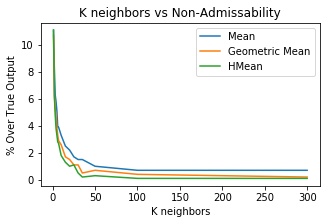

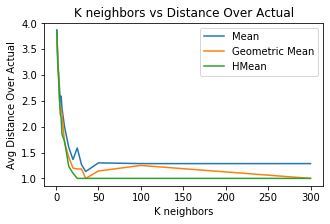

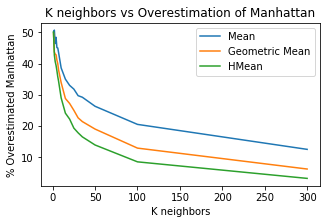

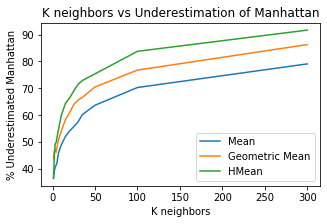

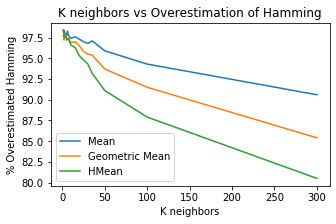

In [78]:
# Matplotlib Plotting

fig = plt.figure(figsize=(5, 3))
plt.plot(K, avg_e_admiss_mean, label='Mean')
plt.plot(K, avg_e_admiss_gmean, label='Geometric Mean')
plt.plot(K, avg_e_admiss_mode, label='HMean')
plt.legend()
plt.title("K neighbors vs Non-Admissability")
plt.xlabel("K neighbors")
plt.ylabel("% Over True Output")
plt.show()


fig = plt.figure(figsize=(5, 3))
plt.plot(K, avg_dist_over_mean, label='Mean')
plt.plot(K, avg_dist_over_gmean, label='Geometric Mean')
plt.plot(K, avg_dist_over_mode, label='HMean')
plt.legend()
plt.title("K neighbors vs Distance Over Actual")
plt.xlabel("K neighbors")
plt.ylabel("Avg Distance Over Actual")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(K, perc_over_man_mean, label='Mean')
plt.plot(K, perc_over_man_gmean, label='Geometric Mean')
plt.plot(K, perc_over_man_mode, label='HMean')
plt.legend()
plt.title("K neighbors vs Overestimation of Manhattan")
plt.xlabel("K neighbors")
plt.ylabel("% Overestimated Manhattan")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(K, perc_under_man_mean, label='Mean')
plt.plot(K, perc_under_man_gmean, label='Geometric Mean')
plt.plot(K, perc_under_man_mode, label='HMean')
plt.legend()
plt.title("K neighbors vs Underestimation of Manhattan")
plt.xlabel("K neighbors")
plt.ylabel("% Underestimated Manhattan")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(K, perc_over_ham_mean, label='Mean')
plt.plot(K, perc_over_ham_gmean, label='Geometric Mean')
plt.plot(K, perc_over_ham_mode, label='HMean')
plt.legend()
plt.title("K neighbors vs Overestimation of Hamming")
plt.xlabel("K neighbors")
plt.ylabel("% Overestimated Hamming")
plt.show()

In [ ]:
# Matplotlib Plotting Corrections
'''
avg_e_admiss_mean = [x / 10 for x in avg_e_admiss_mean]
#perc_over_man_mean = [x / 10 for x in perc_over_man_mean]
#perc_under_man_mean = [x / 10 for x in perc_under_man_mean]
#perc_over_ham_mean = [x / 10 for x in perc_over_ham_mean]

avg_e_admiss_gmean = [x / 10 for x in avg_e_admiss_gmean]
#perc_over_man_gmean = [x / 10 for x in perc_over_man_gmean]
#perc_under_man_gmean = [x / 10 for x in perc_under_man_gmean]
#perc_over_ham_gmean = [x / 10 for x in perc_over_ham_gmean]

avg_e_admiss_mode = [x / 10 for x in avg_e_admiss_mode]
#perc_over_man_mode = [x / 10 for x in perc_over_man_mode]
#perc_under_man_mode = [x / 10 for x in perc_under_man_mode]
#perc_over_ham_mode = [x / 10 for x in perc_over_ham_mode]
'''

In [79]:
'''
print(avg_e_admiss_mean, "\n")
print(perc_over_man_mean, "\n")
print(perc_under_man_mean, "\n")
print(perc_over_ham_mean, "\n")


print(avg_e_admiss_gmean, "\n")
print(perc_over_man_gmean, "\n")
print(perc_under_man_gmean, "\n")
print(perc_over_ham_gmean, "\n")

print(avg_e_admiss_mode, "\n")
print(perc_over_man_mode, "\n")
print(perc_under_man_mode, "\n")
print(perc_over_ham_mode, "\n")
'''

'\nprint(avg_e_admiss_mean, "\n")\nprint(perc_over_man_mean, "\n")\nprint(perc_under_man_mean, "\n")\nprint(perc_over_ham_mean, "\n")\n\n\nprint(avg_e_admiss_gmean, "\n")\nprint(perc_over_man_gmean, "\n")\nprint(perc_under_man_gmean, "\n")\nprint(perc_over_ham_gmean, "\n")\n\nprint(avg_e_admiss_mode, "\n")\nprint(perc_over_man_mode, "\n")\nprint(perc_under_man_mode, "\n")\nprint(perc_over_ham_mode, "\n")\n'